In [1]:
# Importing libraries

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
import sklearn.linear_model as linear_model
from sklearn.linear_model import Lasso
from scipy import stats
from xgboost import XGBRegressor # 부스팅-XGBoost회귀
from lightgbm import LGBMRegressor # 부스팅-LightGBM 회귀
import xgboost as xgb
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, Normalizer
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer, r2_score
import warnings         # warnings : 버전 충돌 및 특정 예외 처리를 위해 불러온 내장 모듈
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [2]:
pd.set_option('display.max_row', 500)
pd.set_option('display.max_columns', 100)

# 1. EDA

In [3]:
train = pd.read_csv('./train.csv')

In [4]:
train.head()

,Price,Age,KM,FuelType,HP,MetColor,Automatic,CC,Doors,Weight
0,13500,23,46986,Diesel,90,1,0,2000,3,1165
1,13750,23,72937,Diesel,90,1,0,2000,3,1165
2,13950,24,41711,Diesel,90,1,0,2000,3,1165
3,14950,26,48000,Diesel,90,0,0,2000,3,1165
4,13750,30,38500,Diesel,90,0,0,2000,3,1170


## 독립변수, 종속변수 정리

- Feature(X, 독립 변수)

    1. Age = 나이
    1. KM = Km수
    1. FuelType = 연료타입
    1. HP
    1. MetColor
        - S = Southampton
        - Q = Queenstown
        - C = Cherbourg
    1. Automatic
    1. CC
    1. Doors
    1. Weight

- Target

    1. Price = 가격 ( 0 = 사망, 1 = 생존 )

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1436 entries, 0 to 1435
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Price      1436 non-null   int64 
 1   Age        1436 non-null   int64 
 2   KM         1436 non-null   int64 
 3   FuelType   1436 non-null   object
 4   HP         1436 non-null   int64 
 5   MetColor   1436 non-null   int64 
 6   Automatic  1436 non-null   int64 
 7   CC         1436 non-null   int64 
 8   Doors      1436 non-null   int64 
 9   Weight     1436 non-null   int64 
dtypes: int64(9), object(1)
memory usage: 112.3+ KB


In [6]:
train.shape

(1436, 10)

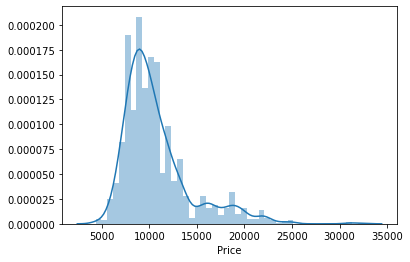

In [7]:
# 로그함수를 이용한 스케일링 필요.

sns.distplot(train['Price']);

In [8]:
train['Price'] = np.log1p(train['Price'])

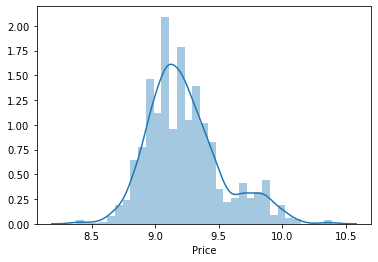

In [9]:
sns.distplot(train['Price']);

In [10]:
# Train data 결측치 (x)

train_na = (train.isnull().sum() / len(train)) * 100
train_na = train_na.drop(train_na[train_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Value Ratio' :train_na})
missing_data.head(20)

,Missing Value Ratio


In [11]:
# 수치형 데이터 확인 ( 기술통계량값 출력으로 )

train.describe()

,Price,Age,KM,HP,MetColor,Automatic,CC,Doors,Weight
count,1436.000000,1436.000000,1436.000000,1436.000000,1436.000000,1436.000000,1436.000000,1436.000000,1436.00000
mean,9.233802,55.947075,68533.259749,101.502089,0.674791,0.055710,1566.827994,4.033426,1072.45961
std,0.296199,18.599988,37506.448872,14.981080,0.468616,0.229441,187.182436,0.952677,52.64112
min,8.378161,1.000000,1.000000,69.000000,0.000000,0.000000,1300.000000,2.000000,1000.00000
25%,9.042040,44.000000,43000.000000,90.000000,0.000000,0.000000,1400.000000,3.000000,1040.00000
50%,9.200391,61.000000,63389.500000,110.000000,1.000000,0.000000,1600.000000,4.000000,1070.00000
75%,9.388570,70.000000,87020.750000,110.000000,1.000000,0.000000,1600.000000,5.000000,1085.00000
max,10.389026,80.000000,243000.000000,192.000000,1.000000,1.000000,2000.000000,5.000000,1615.00000


In [12]:
# 범주형 데이터 확인 

train.describe(include=['O'])

,FuelType
count,1436
unique,3
top,Petrol
freq,1264


In [13]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1436 entries, 0 to 1435
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Price      1436 non-null   float64
 1   Age        1436 non-null   int64  
 2   KM         1436 non-null   int64  
 3   FuelType   1436 non-null   object 
 4   HP         1436 non-null   int64  
 5   MetColor   1436 non-null   int64  
 6   Automatic  1436 non-null   int64  
 7   CC         1436 non-null   int64  
 8   Doors      1436 non-null   int64  
 9   Weight     1436 non-null   int64  
dtypes: float64(1), int64(8), object(1)
memory usage: 112.3+ KB


# 2. 데이터 전처리

In [14]:
df1 = pd.get_dummies(train['FuelType'], prefix = 'FuelType' ,drop_first=False)

In [15]:
train = pd.concat([train, df1], axis=1 )

In [16]:
train.drop('FuelType', axis = 1, inplace = True)

In [17]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1436 entries, 0 to 1435
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Price            1436 non-null   float64
 1   Age              1436 non-null   int64  
 2   KM               1436 non-null   int64  
 3   HP               1436 non-null   int64  
 4   MetColor         1436 non-null   int64  
 5   Automatic        1436 non-null   int64  
 6   CC               1436 non-null   int64  
 7   Doors            1436 non-null   int64  
 8   Weight           1436 non-null   int64  
 9   FuelType_CNG     1436 non-null   uint8  
 10  FuelType_Diesel  1436 non-null   uint8  
 11  FuelType_Petrol  1436 non-null   uint8  
dtypes: float64(1), int64(8), uint8(3)
memory usage: 105.3 KB


In [18]:
train.head()

,Price,Age,KM,HP,MetColor,Automatic,CC,Doors,Weight,FuelType_CNG,FuelType_Diesel,FuelType_Petrol
0,9.510519,23,46986,90,1,0,2000,3,1165,0,1,0
1,9.528867,23,72937,90,1,0,2000,3,1165,0,1,0
2,9.543306,24,41711,90,1,0,2000,3,1165,0,1,0
3,9.612533,26,48000,90,0,0,2000,3,1165,0,1,0
4,9.528867,30,38500,90,0,0,2000,3,1170,0,1,0


## 전처리 완료

# 3. 모델링

In [19]:
y = train['Price']
y.shape

(1436,)

In [20]:
X = train.drop('Price', axis=1)
X.shape

(1436, 11)

In [21]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2)

In [22]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1148, 11)
(288, 11)
(1148,)
(288,)


In [23]:
def test_model(model, X_train, y_train):
    cv = KFold(n_splits = 10, shuffle=True)
    r2 = make_scorer(r2_score)
    r2_val_score = cross_val_score(model, X_train, y_train, cv=cv, scoring = r2, n_jobs=-1)
    score = [r2_val_score.mean()]
    return score

In [24]:
def rsme(model, X, y):
    cv_scores = -cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=10, n_jobs=-1)
    return np.sqrt(cv_scores)

### Lasso회귀를 이용하여 유의미한 변수파악

In [25]:
## Tuning parameters

param_grid = {'alpha':[0.0001,0.001,0.01,1.,5.,10.,25.],'max_iter':[50000]}
lasso = GridSearchCV(Lasso(), cv=5, param_grid=param_grid, scoring='neg_mean_squared_error', n_jobs=-1)
lasso.fit(X_train, y_train)
alpha = lasso.best_params_['alpha']

# Home in
param_grid = {'alpha':[x/100. * alpha for x in range(50,150,5)],'max_iter':[50000]}
lasso = GridSearchCV(Lasso(), cv=5, param_grid=param_grid, scoring='neg_mean_squared_error', n_jobs=-1)
lasso.fit(X_train, y_train)
alpha = lasso.best_params_['alpha']
lasso = lasso.best_estimator_

print('Lasso -> Train RSME: {:,.5f}| alpha {:,.5f}'.format(rsme(lasso, X_train, y_train).mean(),alpha))

Lasso -> Train RSME: 0.11738| alpha 0.00005


In [26]:
dfColumns = X_train.columns

Lasso dropped 1 of 11 features.


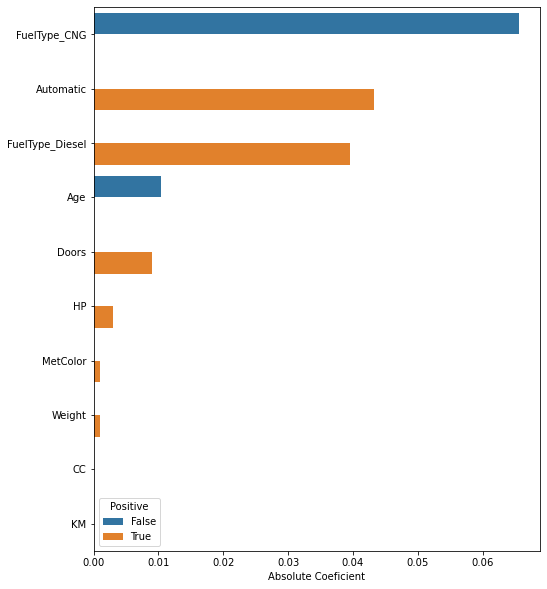

In [27]:
coefs = pd.DataFrame({'coefs':lasso.coef_,'Positive':lasso.coef_>0}, index=dfColumns)
coefs['coefs_abs'] = np.abs(coefs.coefs)
print('Lasso dropped {} of {} features.'.format(sum(coefs.coefs==0), coefs.shape[0]))

top_coefs = coefs.sort_values('coefs_abs', ascending=False).head(10) # 상위 10개 유의미한 변수
plt.figure(figsize=(8,10))
sns.barplot(top_coefs.coefs_abs, top_coefs.index, orient='h', hue=top_coefs.Positive)
plt.title=('Lasso Regression: Top Features')
plt.xlabel('Absolute Coeficient')
plt.show()

In [28]:
# 상위 10개 유의미한 변수

top_coefs

,coefs,Positive,coefs_abs
FuelType_CNG,-0.065557,False,0.065557
Automatic,0.043250,True,0.043250
FuelType_Diesel,0.039539,True,0.039539
Age,-0.010433,False,0.010433
Doors,0.008970,True,0.008970
HP,0.003022,True,0.003022
MetColor,0.001063,True,0.001063
Weight,0.000979,True,0.000979
CC,-0.000089,False,0.000089
KM,-0.000002,False,0.000002


In [29]:
# Linear Regression

LR = linear_model.LinearRegression(n_jobs=-1)
acc_LR = test_model(LR, X_train, y_train)

LR_rsme = rsme(LR, X_train, y_train)

print('Score: {:.5f}'.format((acc_LR[0])))
print('RSME: {:.5f}'.format(LR_rsme.mean()))

Score: 0.83593
RSME: 0.11737


In [30]:
# Support Vector Regressor

svr_reg = SVR(kernel='rbf')
acc_SVR = test_model(svr_reg, X_train, y_train)

svr_rsme = rsme(svr_reg, X_train, y_train)
print('Score: {:.5f}'.format((acc_SVR[0])))
print('RSME: {:.5f}'.format(svr_rsme.mean()))

Score: 0.44148
RSME: 0.22010


In [31]:
#Decision Tree
dt_reg = DecisionTreeRegressor(random_state=21)
acc_tree = test_model(dt_reg, X_train, y_train)

dt_rsme = rsme(dt_reg, X_train, y_train)
print('Score: {:.5f}'.format((acc_tree[0])))
print('RSME: {:.5f}'.format(dt_rsme.mean()))

Score: 0.75624
RSME: 0.14979


In [32]:
# Random Forest
rf_reg = RandomForestRegressor(n_estimators = 1000, n_jobs=-1)
acc_rf = test_model(rf_reg, X_train, y_train)

rf_rsme = rsme(rf_reg, X_train, y_train)
print('Score: {:.5f}'.format((acc_rf[0])))
print('RSME: {:.5f}'.format(rf_rsme.mean()))

Score: 0.85497
RSME: 0.11154


In [33]:
# Bagging Regressor
br_reg = BaggingRegressor(n_estimators=1000, n_jobs=-1)
acc_br = test_model(br_reg, X_train, y_train)

br_rsme = rsme(br_reg, X_train, y_train)
print('Score: {:.5f}'.format((acc_br[0])))
print('RSME: {:.5f}'.format(br_rsme.mean()))

Score: 0.85241
RSME: 0.11150


In [34]:
# Gradient Boosting Regressor
gbr_reg = GradientBoostingRegressor(n_estimators=1000, learning_rate=0.05, loss='ls')
acc_gbr = test_model(gbr_reg, X_train, y_train)

gbr_rsme = rsme(gbr_reg, X_train, y_train)
print('Score: {:.5f}'.format((acc_gbr[0])))
print('RSME: {:.5f}'.format(gbr_rsme.mean()))

Score: 0.85336
RSME: 0.11106


In [35]:
# XGBoost

xgb_reg = xgb.XGBRegressor()

acc_xgb = test_model(xgb_reg, X_train[top_coefs.index], y_train)
xgb_rsme = rsme(xgb_reg, X_train[top_coefs.index], y_train)

print('Score: {:.5f}'.format((acc_xgb[0])))
print('RSME: {:.5f}'.format(xgb_rsme.mean()))

Score: 0.84426
RSME: 0.11783


In [36]:
# Ligth GBM

lgb_reg = LGBMRegressor()

acc_lgb = test_model(lgb_reg, X_train[top_coefs.index], y_train)
lgb_rsme = rsme(lgb_reg, X_train[top_coefs.index], y_train)

print('Score: {:.5f}'.format((acc_lgb[0])))
print('RSME: {:.5f}'.format(lgb_rsme.mean()))

Score: 0.85974
RSME: 0.11096


In [37]:
results = pd.DataFrame({
    'Model': ['Linear Regression', 'Support Vector Regressor', 
              'Decision Tree', 'Random Forest', 'Bagging Regressor', 'Gradient Boosting Regressor ','XGBoost','Light GBM'],
    'Score': [acc_LR[0], acc_SVR[0], acc_tree[0], acc_rf[0], acc_br[0], acc_gbr[0], acc_xgb[0], acc_lgb[0]],
    'RSME': [LR_rsme.mean(), svr_rsme.mean(), dt_rsme.mean(), rf_rsme.mean(), br_rsme.mean(), gbr_rsme.mean(), 
             xgb_rsme.mean(), lgb_rsme.mean()],
    'RMSE_std':[LR_rsme.std(), svr_rsme.std(), dt_rsme.std(), rf_rsme.std(), br_rsme.std(), gbr_rsme.std(), 
                xgb_rsme.std(), lgb_rsme.std()]
})

result = results.sort_values(by='RSME', ascending=True)
result = result.set_index('Model')
display(result.head(9))

,Score,RSME,RMSE_std
Model,,,
Light GBM,0.859735,0.110962,0.008053
Gradient Boosting Regressor,0.853358,0.111061,0.008027
Bagging Regressor,0.852408,0.111505,0.008232
Random Forest,0.854968,0.111544,0.008382
Linear Regression,0.835926,0.117369,0.013723
XGBoost,0.844260,0.117827,0.010552
Decision Tree,0.756238,0.149789,0.018370
Support Vector Regressor,0.441482,0.220097,0.022887


# 4. 하이퍼파라미터 튜닝

## 4-1. 랜덤 포레스트 (RandomizedSearchCV)

In [38]:
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest

n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

# Number of features to consider at every split

max_features = ['auto', 'sqrt']

# Maximum number of levels in tree

max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]

max_depth.append(None)

# Minimum number of samples required to split a node

min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node

min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree

bootstrap = [True, False]

# Create the random grid

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}


In [39]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune

rf = RandomForestRegressor()

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores

rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, n_jobs = -1)

# Fit the random search model

rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   12.2s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  2.4min finished


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   verbose=2)

In [40]:
rf_random.best_estimator_

RandomForestRegressor(bootstrap=False, max_depth=20, max_features='sqrt',
                      min_samples_leaf=2, min_samples_split=10,
                      n_estimators=1000)

In [56]:
rf_best = rf_random.best_estimator_

In [57]:
rf_best.fit(X_train, y_train)

RandomForestRegressor(bootstrap=False, max_depth=20, max_features='sqrt',
                      min_samples_leaf=2, min_samples_split=10,
                      n_estimators=1000)

In [58]:
acc_rf_best = test_model(rf_best, X_train, y_train)
rf_best_rsme = rsme(rf_best, X_train, y_train)

print('Score: {:.5f}'.format((acc_rf_best[0])))
print('RSME: {:.5f}'.format(rf_best_rsme.mean()))
print('RSME_std: {:.5f}'.format(rf_best_rsme.std()))

Score: 0.85892
RSME: 0.11094
RSME_std: 0.00722


## 4-2. Light GBM(RandomizedSearchCV)

In [59]:
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest

n_estimators = [int(x) for x in np.linspace(start = 100, stop = 2000, num = 100)]

# Number of features to consider at every split

max_features = ['auto', 'sqrt']

# Maximum number of levels in tree

max_depth = [int(x) for x in np.linspace(10, 120, num = 20)]

max_depth.append(None)

# Minimum number of samples required to split a node

min_samples_split = [3,6,9,10]

# Minimum number of samples required at each leaf node

min_samples_leaf = [ 1, 3, 6, 9 ]

# Method of selecting samples for training each tree

bootstrap = [True, False]

# Create the random grid

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [45]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune

lg_cl = LGBMRegressor()

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores

lg_random = RandomizedSearchCV(estimator = lg_cl, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, n_jobs = -1)

# Fit the random search model

lg_random.fit(X_train, y_train)
print(lg_random.best_estimator_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   26.3s


LGBMRegressor(bootstrap=False, max_depth=91, max_features='auto',
              min_samples_leaf=3, min_samples_split=6)


[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   50.7s finished


In [46]:
lg_random.best_estimator_

LGBMRegressor(bootstrap=False, max_depth=91, max_features='auto',
              min_samples_leaf=3, min_samples_split=6)

In [60]:
lg_random_best = lg_random.best_estimator_

In [62]:
lg_random_best.fit(X_train, y_train)

LGBMRegressor(bootstrap=False, max_depth=91, max_features='auto',
              min_samples_leaf=3, min_samples_split=6)

In [63]:
acc_lg_random_best = test_model(lg_random_best, X_train, y_train)
lg_random_best_rsme = rsme(lg_random_best, X_train, y_train)

print('Score: {:.5f}'.format((acc_lg_random_best[0])))
print('RSME: {:.5f}'.format(lg_random_best_rsme.mean()))
print('RSME_std: {:.5f}'.format(lg_random_best_rsme.std()))

Score: 0.85057
RSME: 0.11090
RSME_std: 0.00894


## 4-3. Light GBM(Bayesian optimization)

In [64]:
bayes_params = {
    'num_leaves': (4, 99),
    'colsample_bytree':(0.5, 1), 
    'subsample': (0.5, 1),
    'max_depth': (4, 128),
    'reg_alpha': (0, 0.9),
    'reg_lambda': (0, 0.9), 
    'min_split_gain': (0.001, 0.1),
    'min_child_weight':(1, 99)
}

In [65]:
from sklearn.metrics import mean_squared_error

def lgb_rmse_eval(num_leaves, colsample_bytree, subsample, max_depth, reg_alpha, reg_lambda, min_split_gain, min_child_weight):
    
    params = {
        "n_estimator":500,
        "learning_rate":0.05,
        'num_leaves': int(round(num_leaves)),
        'colsample_bytree': colsample_bytree, 
        'subsample': subsample,
        'max_depth': int(round(max_depth)),
        'reg_alpha': reg_alpha,
        'reg_lambda': reg_lambda, 
        'min_split_gain': min_split_gain,
        'min_child_weight': min_child_weight,
        'verbosity': -1
    }
    print("params:", params)
    lgb_model = LGBMRegressor(**params)
    lgb_model.fit(X_train, y_train, eval_set=[(X_test, y_test)], eval_metric="rmse", verbose=10)
    best_iter = lgb_model.best_iteration_
    print('best_iter:', best_iter)
    
    y_preds = lgb_model.predict(X_test)
    mse = mean_squared_error(y_test, y_preds)
    rmse = np.sqrt(mse) 

    print('MSE : {0:.3f} , RMSE : {1:.3F}'.format(mse , rmse))
    print('Variance score = R제곱 -> 1에 가까울 수록 좋다 (0과 1사이)')
    print('Variance score : {0:.3f}'.format(r2_score(y_test, y_preds)))
    return rmse
    
    

In [51]:
from bayes_opt import BayesianOptimization

BO_lgb = BayesianOptimization(lgb_rmse_eval, bayes_params)

In [52]:
BO_lgb.maximize(init_points=5, n_iter=10)

|   iter    |  target   | colsam... | max_depth | min_ch... | min_sp... | num_le... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------
params: {'n_estimator': 500, 'learning_rate': 0.05, 'num_leaves': 53, 'colsample_bytree': 0.5701930631341178, 'subsample': 0.9717660543923188, 'max_depth': 102, 'reg_alpha': 0.7953654292259065, 'reg_lambda': 0.46405598956568256, 'min_split_gain': 0.0033295794609507646, 'min_child_weight': 85.2637933602037, 'verbosity': -1}
[10]	valid_0's rmse: 0.206524	valid_0's l2: 0.0426521
[20]	valid_0's rmse: 0.162587	valid_0's l2: 0.0264346
[30]	valid_0's rmse: 0.136957	valid_0's l2: 0.0187572
[40]	valid_0's rmse: 0.121842	valid_0's l2: 0.0148455
[50]	valid_0's rmse: 0.113955	valid_0's l2: 0.0129858
[60]	valid_0's rmse: 0.109839	valid_0's l2: 0.0120646
[70]	valid_0's rmse: 0.107695	valid_0's l2: 0.0115983
[80]	valid_0's rmse: 0.106901	valid_0's l2: 0.0114278

params: {'n_estimator': 500, 'learning_rate': 0.05, 'num_leaves': 54, 'colsample_bytree': 0.7376612709225577, 'subsample': 0.5769530627841613, 'max_depth': 4, 'reg_alpha': 0.10780212599990241, 'reg_lambda': 0.4733589595812941, 'min_split_gain': 0.03357242213640815, 'min_child_weight': 98.81863652112597, 'verbosity': -1}
[10]	valid_0's rmse: 0.200404	valid_0's l2: 0.0401618
[20]	valid_0's rmse: 0.156436	valid_0's l2: 0.0244724
[30]	valid_0's rmse: 0.132541	valid_0's l2: 0.0175672
[40]	valid_0's rmse: 0.120302	valid_0's l2: 0.0144725
[50]	valid_0's rmse: 0.113666	valid_0's l2: 0.01292
[60]	valid_0's rmse: 0.110849	valid_0's l2: 0.0122876
[70]	valid_0's rmse: 0.10941	valid_0's l2: 0.0119706
[80]	valid_0's rmse: 0.108496	valid_0's l2: 0.0117714
[90]	valid_0's rmse: 0.107769	valid_0's l2: 0.0116143
[100]	valid_0's rmse: 0.10744	valid_0's l2: 0.0115433
best_iter: None
MSE : 0.012 , RMSE : 0.107
Variance score = R제곱 -> 1에 가까울 수록 좋다 (0과 1사이)
Variance score : 0.862
|  8        |  0.1074   |  0.

params: {'n_estimator': 500, 'learning_rate': 0.05, 'num_leaves': 5, 'colsample_bytree': 0.6624164414728453, 'subsample': 0.9411059641973716, 'max_depth': 124, 'reg_alpha': 0.1617022125641256, 'reg_lambda': 0.3553185527997316, 'min_split_gain': 0.060883980827247844, 'min_child_weight': 98.86529702304419, 'verbosity': -1}
[10]	valid_0's rmse: 0.203258	valid_0's l2: 0.0413137
[20]	valid_0's rmse: 0.159263	valid_0's l2: 0.0253647
[30]	valid_0's rmse: 0.13467	valid_0's l2: 0.0181359
[40]	valid_0's rmse: 0.1215	valid_0's l2: 0.0147623
[50]	valid_0's rmse: 0.114097	valid_0's l2: 0.0130182
[60]	valid_0's rmse: 0.110865	valid_0's l2: 0.012291
[70]	valid_0's rmse: 0.109147	valid_0's l2: 0.0119131
[80]	valid_0's rmse: 0.108291	valid_0's l2: 0.0117269
[90]	valid_0's rmse: 0.107773	valid_0's l2: 0.011615
[100]	valid_0's rmse: 0.107678	valid_0's l2: 0.0115946
best_iter: None
MSE : 0.012 , RMSE : 0.108
Variance score = R제곱 -> 1에 가까울 수록 좋다 (0과 1사이)
Variance score : 0.861
|  15       |  0.1077   |  0.

In [54]:
BO_lgb.max

{'target': 0.1076784169505616,
 'params': {'colsample_bytree': 0.6624164414728453,
  'max_depth': 123.63983462356367,
  'min_child_weight': 98.86529702304419,
  'min_split_gain': 0.060883980827247844,
  'num_leaves': 4.652744324392388,
  'reg_alpha': 0.1617022125641256,
  'reg_lambda': 0.3553185527997316,
  'subsample': 0.9411059641973716}}

In [66]:
max_params = BO_lgb.max['params']

max_params['num_leaves'] = int(round(max_params['num_leaves']))
max_params['max_depth'] = int(round(max_params['max_depth']))

lgbm_clf_bayes_best = LGBMRegressor(n_estimators=1000, learning_rate=0.001, **max_params)

evals = [(X_test, y_test)]
lgbm_clf_bayes_best.fit(X_train, y_train, eval_metric="rmse", eval_set=evals, verbose=True)

# accuracy score가 아니라 mse 와 rmse 로 확인 0에 가까울 수록 좋다.

y_preds = lightgbmregressor.predict(X_test)
mse = mean_squared_error(y_test, y_preds)
rmse = np.sqrt(mse)

print('MSE : {0:.3f} , RMSE : {1:.3F}'.format(mse , rmse))
print('Variance score = R제곱 -> 1에 가까울 수록 좋다 (0과 1사이)')
print('Variance score : {0:.3f}'.format(r2_score(y_test, y_preds)))

[1]	valid_0's rmse: 0.289038	valid_0's l2: 0.0835428
[2]	valid_0's rmse: 0.288812	valid_0's l2: 0.0834121
[3]	valid_0's rmse: 0.288586	valid_0's l2: 0.0832817
[4]	valid_0's rmse: 0.288354	valid_0's l2: 0.0831482
[5]	valid_0's rmse: 0.288185	valid_0's l2: 0.0830505
[6]	valid_0's rmse: 0.28796	valid_0's l2: 0.0829208
[7]	valid_0's rmse: 0.287735	valid_0's l2: 0.0827913
[8]	valid_0's rmse: 0.287504	valid_0's l2: 0.0826588
[9]	valid_0's rmse: 0.28728	valid_0's l2: 0.0825298
[10]	valid_0's rmse: 0.287056	valid_0's l2: 0.0824011
[11]	valid_0's rmse: 0.286832	valid_0's l2: 0.0822726
[12]	valid_0's rmse: 0.286608	valid_0's l2: 0.0821444
[13]	valid_0's rmse: 0.286483	valid_0's l2: 0.0820725
[14]	valid_0's rmse: 0.28626	valid_0's l2: 0.0819447
[15]	valid_0's rmse: 0.286031	valid_0's l2: 0.0818138
[16]	valid_0's rmse: 0.285809	valid_0's l2: 0.0816865
[17]	valid_0's rmse: 0.285641	valid_0's l2: 0.0815909
[18]	valid_0's rmse: 0.285565	valid_0's l2: 0.0815472
[19]	valid_0's rmse: 0.285343	valid_0's 

[444]	valid_0's rmse: 0.216366	valid_0's l2: 0.0468144
[445]	valid_0's rmse: 0.216217	valid_0's l2: 0.0467499
[446]	valid_0's rmse: 0.216072	valid_0's l2: 0.0466873
[447]	valid_0's rmse: 0.215997	valid_0's l2: 0.0466547
[448]	valid_0's rmse: 0.215856	valid_0's l2: 0.046594
[449]	valid_0's rmse: 0.215712	valid_0's l2: 0.0465317
[450]	valid_0's rmse: 0.215571	valid_0's l2: 0.0464709
[451]	valid_0's rmse: 0.215423	valid_0's l2: 0.046407
[452]	valid_0's rmse: 0.215282	valid_0's l2: 0.0463464
[453]	valid_0's rmse: 0.215142	valid_0's l2: 0.0462859
[454]	valid_0's rmse: 0.214999	valid_0's l2: 0.0462248
[455]	valid_0's rmse: 0.214856	valid_0's l2: 0.0461632
[456]	valid_0's rmse: 0.214716	valid_0's l2: 0.0461031
[457]	valid_0's rmse: 0.214575	valid_0's l2: 0.0460423
[458]	valid_0's rmse: 0.214435	valid_0's l2: 0.0459824
[459]	valid_0's rmse: 0.214295	valid_0's l2: 0.0459223
[460]	valid_0's rmse: 0.21419	valid_0's l2: 0.0458773
[461]	valid_0's rmse: 0.214049	valid_0's l2: 0.045817
[462]	valid_0'

[899]	valid_0's rmse: 0.169018	valid_0's l2: 0.0285671
[900]	valid_0's rmse: 0.168967	valid_0's l2: 0.0285499
[901]	valid_0's rmse: 0.168879	valid_0's l2: 0.0285203
[902]	valid_0's rmse: 0.168796	valid_0's l2: 0.0284922
[903]	valid_0's rmse: 0.168709	valid_0's l2: 0.0284626
[904]	valid_0's rmse: 0.168663	valid_0's l2: 0.0284472
[905]	valid_0's rmse: 0.168576	valid_0's l2: 0.0284177
[906]	valid_0's rmse: 0.168488	valid_0's l2: 0.0283882
[907]	valid_0's rmse: 0.168404	valid_0's l2: 0.0283601
[908]	valid_0's rmse: 0.168341	valid_0's l2: 0.0283387
[909]	valid_0's rmse: 0.168254	valid_0's l2: 0.0283094
[910]	valid_0's rmse: 0.168167	valid_0's l2: 0.0282802
[911]	valid_0's rmse: 0.16808	valid_0's l2: 0.0282509
[912]	valid_0's rmse: 0.167998	valid_0's l2: 0.0282233
[913]	valid_0's rmse: 0.167935	valid_0's l2: 0.0282021
[914]	valid_0's rmse: 0.167847	valid_0's l2: 0.0281726
[915]	valid_0's rmse: 0.167761	valid_0's l2: 0.0281437
[916]	valid_0's rmse: 0.167672	valid_0's l2: 0.0281139
[917]	valid

NameError: name 'lightgbmregressor' is not defined

In [67]:
lgbm_clf_bayes_best

LGBMRegressor(colsample_bytree=0.6624164414728453, learning_rate=0.001,
              max_depth=124, min_child_weight=98.86529702304419,
              min_split_gain=0.060883980827247844, n_estimators=1000,
              num_leaves=5, reg_alpha=0.1617022125641256,
              reg_lambda=0.3553185527997316, subsample=0.9411059641973716)

In [68]:
acc_lgbm_clf_bayes_best = test_model(lgbm_clf_bayes_best, X_train, y_train)
lgbm_clf_bayes_best_rsme = rsme(lgbm_clf_bayes_best, X_train, y_train)

print('Score: {:.5f}'.format((acc_lgbm_clf_bayes_best[0])))
print('RSME: {:.5f}'.format(lgbm_clf_bayes_best_rsme.mean()))
print('RSME_std: {:.5f}'.format(lgbm_clf_bayes_best_rsme.std()))

Score: 0.65690
RSME: 0.17388
RSME_std: 0.01394
